In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from torch.utils.data import Dataset
import torch
import pickle
import mne
import numpy as np
import time

class Sleepedf_dataset(Dataset):
    def __init__(self, files):
        self.files = files
        max_value = 0.
        min_value = 0.

        for i in range(len(self.files)):
            sample = np.load(files[i])['x']
            temp_max = sample.max()
            temp_min = sample.min()
            max_value = np.max([max_value, temp_max])
            min_value = np.min([min_value, temp_min])
        

        self.max_value = max_value
        self.min_value = min_value

    def preprocessing(self, data):
        data_max = np.max(data,axis = 1, keepdims=True) # max value of each channels
        data_min = np.min(data,axis = 1, keepdims=True) # shape = c,t
        c,t = data.shape
        
        return data/data_max*np.ones((c,t)) - (data_max - data_min)*np.ones((c,t))/(self.max_value - self.min_value)

    def one_hot_encoding(self,y):
        if y == '1':
          y = np.array([0,1,0,0,0,0])
        elif y == '2':
          y = np.array([0,0,1,0,0,0])   
        elif y == '3':
          y = np.array([0,0,0,1,0,0])
        elif y == '4':
          y = np.array([0,0,0,0,1,0])
        elif y == 'R':
          y = np.array([0,0,0,0,0,1])
        else: # W
          y = np.array([1,0,0,0,0,0])      
        return y  


    def __getitem__(self, index):          
        sample = np.load(self.files[index])  
        y = self.one_hot_encoding(sample['y'])
        sample = self.preprocessing(sample['x'])
        return { 'x' : torch.tensor(sample), 
                 'y' : torch.tensor(y)
                   }
          
    def __len__(self):
        return len(self.files)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import glob

SleepEDF_file_list = glob.glob('/content/drive/MyDrive/sleep_edfx/Cutted_EEG/**')
print(len(SleepEDF_file_list))
SleepEDF_list = []
for i in range(len(SleepEDF_file_list)):
    SleepEDF_list.extend(glob.glob(SleepEDF_file_list[i]+'/**'))
print(len(SleepEDF_list))

5
5283


In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(SleepEDF_list, test_size=0.2)#, shuffle=True, random_state=34), #stratify=target
train, val = train_test_split(train, test_size= 0.25)#, shu

In [6]:
train_dataset = Sleepedf_dataset(train)
val_dataset = Sleepedf_dataset(val)
test_dataset = Sleepedf_dataset(test)

In [7]:
!pip install separableconv-torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import numpy as np
import torch
import torch.nn as nn
from mne.filter import filter_data, notch_filter
import matplotlib.pyplot as plt


class Encoder(nn.Module):
    def __init__(self, fs, encode_info):
        super(Encoder, self).__init__()
        #spectral layer means spectral convolution
        #self.bac_layer is consist of several SeparableConv2d, which plays the role of temporal separable convolution
        #convolution layer are initiated by xavier_uniform initization
        #Input are Normalized by self.bn(=torch.nn.BatchNorm2d)
        #[batch, electrode, length] -> [batch, electrode, Feature]
        self.fs = fs
        self.elu = nn.ELU()
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.bn = nn.BatchNorm1d(1)
        self.activation = nn.LeakyReLU()

        self.spectral_layer = nn.Conv1d(1, 10, int(self.fs/2), padding="same")

        # self.bac_layer = nn.Sequential()
        # for i, arg in enumerate(encode_info):
        #     input_dim, output_dim, kernel_size = arg
        #     self.bac_layer.add_module("temporal_conv_"+str(i),
        #                           nn.Conv1d(input_dim, output_dim, kernel_size, padding = 'same'))
        #     self.bac_layer.add_module("ELU",nn.ELU()) 
        
        self.conv1t = nn.Conv1d(10,16, 30, padding ='same')
        self.conv2t = nn.Conv1d(16,32, 15, padding ='same')
        self.conv3t = nn.Conv1d(32,64, 5, padding ='same')
        
        torch.nn.init.xavier_uniform_(self.spectral_layer.weight)
        #self.bac_layer.apply(weight_init_xavier_uniform)

    def forward(self, x):
        x = self.activation(self.spectral_layer(x))
        x = self.activation(self.conv1t(x))
        x = self.activation(self.conv2t(x))
        x = self.activation(self.conv3t(x))

        return x

#Linear layer for SSL classification
class Head_NN(nn.Module):
    def __init__(self):
        super(Head_NN, self).__init__()        
        # self.layer = nn.Sequential(
        #     nn.Dropout(0.5),
        #     nn.Linear(64*length, 5)
        # )
        
        self.layer = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 5)
        )
        
        self.softmax = torch.nn.Softmax()
        # self.layer.apply(weight_init_xavier_uniform)
        self.bn = nn.BatchNorm1d(64)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = torch.mean(x, axis = 2) # Global average pooling into temporal dimension
        # x = self.flatten(x)
        x = self.layer(x)
        x = self.softmax(x)
        return x

class StoppedBandPathway(nn.Module):
    def __init__(self, fs, Unsupervise, encode_info, bands):
        super(StoppedBandPathway, self).__init__()
        self.encoder = Encoder(fs, encode_info)
        self.pretrain = Head_NN()
        self.Unsupervise = Unsupervise


    def forward(self, x):
        x = self.encoder(x)
        x = self.pretrain(x)
        return x

    def getRep(self, x):
        x = self.encoder(x)
        return x


In [9]:
class feature_extractor3(nn.Module):
    def __init__(self):
        super(feature_extractor3,self).__init__()
        
        self.channels = 1 # we use only single channel 
        
        # Activation functions
        self.activation = nn.LeakyReLU()
        # self.bn = nn.BatchNorm1d(1)

        # self.conv2t = nns.SeparableConv1d(16,32,10,padding ='same') (in_channels, out_channels, kernel size,,,) 

        self.softmax = nn.Softmax()
        self.conv1t = nn.Conv1d(1,10, 30, padding ='same') #in_channels, out_channels, kernel_size, 
        self.conv1s = nn.Conv1d(10,10,self.channels)
        self.conv2t = nn.Conv1d(10,20,15,padding ='same') 
        self.conv2s = nn.Conv1d(20,20,self.channels)
        self.conv3t = nn.Conv1d(20,34,5,padding ='same')
        self.conv3s = nn.Conv1d(34,34,self.channels)
        
                  
        # Flatteninig
        self.flatten = nn.Flatten()

        # Dropout
        self.dropout = nn.Dropout(0.5)

        # Decision making
        self.Linear = nn.Linear(256000 ,4) # 

      
    def embedding(self, x):
        x = self.activation(self.conv1t(x))
        f1 = self.activation(self.conv1s(x))

        x = self.activation(self.conv2t(x))
        f2 = self.activation(self.conv2s(x))

        x = self.activation(self.conv3t(x))
        f3 = self.activation(self.conv3s(x))
        
        # multi-scale feature representation by exploiting intermediate features
        feature = torch.cat([f1, f2, f3],dim = 1 )
        
        return feature

    def classifier(self, feature):
        # Flattening, dropout, mapping into the decision nodes
        feature = self.flatten(feature)
        feature = self.dropout(feature)
        y_hat = self.softmax(self.Linear(feature))
        return y_hat    

    def forward(self, x):
        feature = self.embedding(x)
        y_hat = self.classifier(feature)
        return y_hat

In [10]:
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# # import separableconv.nn as snn

# class FeatureEncoder(nn.Module):
#     def __init__(self,x1,x2):
#         super(FeatureEncoder, self).__init__()
#         self.sepctral_rept = x1
#         self.temporal_rept = x2
#         self.conv1 = nn.Conv2d(64,64, (2,1))
#         self.conv2 = nn.Conv2d(64,64, (2,1))


#     def fGAP(self, x):
#         x = torch.tensor(x)
#         x = F.adaptive_avg_pool2d(x, (1, 1))
#         return x

#     def fGVP(self, x):
#          #  x.shape = batch,  channel, feature, time -->
#         x = torch.tensor(x)
#         torch.var(x.view(x.size(0), x.size(1), -1), dim=2)
#         return x    
    

#     def forward(self,b,c,f,t):
#         f_1 = self.sepctral_rept
#         f_2 = self.temporal_rept
#         f_1 = torch.reshape(f_1,(b,f,c,t)) 
#         f_2 = torch.reshape(f_2,(b,f,c,t)) 
#         f_1 = self.conv1(f_1)
#         f_2 = self.conv2(f_2) # b,f,1, t
        
#         # print(f_1.shape,f_2.shape)
#         f_GAP = torch.cat(( self.fGAP(f_1).squeeze(),self.fGAP(f_2).squeeze() ), axis=1)
#         f_GVP = torch.cat((self.fGVP(f_1).squeeze(),self.fGVP(f_2).squeeze()), axis=1)
#         # print(f_GAP.shape,f_GVP.shape)


#         return  f_GAP, f_GVP


# class StatisticianModule(nn.Module):
#     def __init__(self, dense, classes):
#         super(StatisticianModule, self).__init__()
#         self.classes = classes

#         self.softmax = torch.nn.Softmax(dim=1)
#         self.c_dense = nn.Linear(dense, 64*2*2) # 64*2*2

#         self.gap_pwconv = nn.Conv1d(128, dense, 1) 
#         self.gvp_pwconv = nn.Conv1d(128, dense, 1)

#         self.fullconnect = nn.Linear(dense, self.classes)


#     def forward(self, f_GAP, f_GVP):
#         #[batch, gap+gvp] -> [batch,dense]
      
#         c = self.softmax(self.c_dense(torch.cat((f_GAP, f_GVP),axis=1)))
#         # print('c:',c.shape)
#         #[batch, gap, 1] -> [batch, 1, dense] -> [batch, dense]
#         f_GAP_d = self.gap_pwconv(f_GAP.unsqueeze(dim=-1)).squeeze()
#         f_GVP_d = self.gvp_pwconv(f_GVP.unsqueeze(dim=-1)).squeeze()
        
#         f_GAP_dd = torch.sum(c*f_GAP_d,dim=1)
#         f_GVP_dd = torch.sum(c*f_GVP_d,dim=1)
#         # print('f_GAP_dd: ',f_GAP_dd.shape)
#         ALN = torch.div(torch.sub(f_GAP_d.T,f_GAP_dd),f_GAP_dd).T
#         # print('ALN', ALN.shape)

#         y_hat = self.fullconnect(ALN)
#         # print('y_hat: ',y_hat.shape)
#         return y_hat

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# import separableconv.nn as snn

class FeatureEncoder(nn.Module):
    def __init__(self,x1,x2):
        super(FeatureEncoder, self).__init__()
        self.sepctral_rept = x1
        self.temporal_rept = x2
        self.conv1 = nn.Conv2d(64,64, (2,1))
        self.conv2 = nn.Conv2d(64,64, (2,1))


    def fGAP(self, x):
        x = torch.tensor(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        return x

    def fGVP(self, x):
        x = torch.tensor(x)
        torch.var(x.view(x.size(0), x.size(1), -1), dim=2)
        return x    
    

    def forward(self,b,c,f,t):
        f_1 = self.sepctral_rept
        f_2 = self.temporal_rept
        f_1 = torch.reshape(f_1,(b,f,c,t)) 
        f_2 = torch.reshape(f_2,(b,f,c,t)) 
        
        # print(f_1.shape,f_2.shape)
        f_GAP = torch.cat(( self.fGAP(f_1).squeeze(),self.fGAP(f_2).squeeze() ), axis=1)
        f_GVP = torch.cat((self.fGVP(f_1).squeeze(),self.fGVP(f_2).squeeze()), axis=1)
        print(f_GAP.shape,f_GVP.shape)


        return  f_GAP, f_GVP


class StatisticianModule(nn.Module):
    def __init__(self, dense, classes):
        super(StatisticianModule, self).__init__()
        self.classes = classes
        
        self.conv1 = nn.Conv2d(64,64, (2,1))
        self.conv2 = nn.Conv2d(64,64, (2,1))

        self.softmax = torch.nn.Softmax(dim=1)
        self.c_dense = nn.Linear(dense, 64*2*2) # 64*2*2

        self.gap_pwconv = nn.Conv1d(128, dense, 1) 
        self.gvp_pwconv = nn.Conv1d(128, dense, 1)

        self.fullconnect = nn.Linear(dense, self.classes)

        torch.nn.init.xavier_uniform_(self.conv1.weight)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        torch.nn.init.xavier_uniform_(self.c_dense.weight)
        torch.nn.init.xavier_uniform_(self.gap_pwconv.weight)
        torch.nn.init.xavier_uniform_(self.gvp_pwconv.weight)
        torch.nn.init.xavier_uniform_(self.fullconnect.weight)
        

    def GAPGVP(self, x1, x2, b,c,f,t ):
        x1 = torch.reshape(x1,(b,f,c,t)) 
        x2 = torch.reshape(x2,(b,f,c,t)) 
        x1 = self.conv1(x1)
        x2 = self.conv2(x2)

        f_GAP = torch.cat((F.adaptive_avg_pool2d(x1, (1, 1)).squeeze(), F.adaptive_avg_pool2d(x2, (1, 1)).squeeze()), axis=1)
        f_GVP = torch.cat((torch.var(x1.view(x1.size(0), x1.size(1), -1), dim=2),torch.var(x1.view(x1.size(0), x1.size(1), -1), dim=2)), axis=1)
        del x1
        del x2
        return f_GAP, f_GVP

    def forward(self,x1, x2, b,c,f,t):
        f_GAP, f_GVP = self.GAPGVP(x1, x2, b,c,f,t )
        # print(f_GAP.shape, f_GVP.shape)
        c = self.softmax(self.c_dense(torch.cat((f_GAP, f_GVP),axis=1)))
        # print('c:',c.shape)
        #[batch, gap, 1] -> [batch, 1, dense] -> [batch, dense]
        f_GAP_d = self.gap_pwconv(f_GAP.unsqueeze(dim=-1)).squeeze()
        f_GVP_d = self.gvp_pwconv(f_GVP.unsqueeze(dim=-1)).squeeze()
        
        f_GAP_dd = torch.sum(c*f_GAP_d,dim=1)
        f_GVP_dd = torch.sum(c*f_GVP_d,dim=1)
        # print('f_GAP_dd: ',f_GAP_dd.shape)
        ALN = torch.div(torch.sub(f_GAP_d.T,f_GAP_dd),f_GAP_dd).T
        # print('ALN', ALN.shape)

        y_hat = self.fullconnect(ALN)
        # print('y_hat: ',y_hat.shape)
        return y_hat

In [12]:
# import numpy as np
# import torch
# import torch.nn as nn
# import separableconv.nn as nn

# class FeatureEncoder(nn.Module):
#     def __init__(self,x1,x2):
#         super(FeatureEncoder, self).__init__()
#         self.sepctral_rept = x1
#         self.temporal_rept = x2
#         self.conv = nn.Conv2d(1,16, (1,2), padding ='same')
#         #self.GVP = torch.var(dim=-1)

#     def Temporal_GAP(self, x):
#          #  x.shape = batch*channel, feature, time -->
#         x = torch.tensor(x)
#         x = torch.mean(x, 1) # channel
#         x = torch.mean(x, 2) # time
#         return x

#     def Temporal_GVP(self, x):
#          #  x.shape = batch,  channel, feature, time -->
#         x = torch.tensor(x)
#         x = torch.var(x, 1) # channel
#         x = torch.var(x, 2) # time
#         return x    

#     def forward(self,b,c,f,t):
#         f_1 = self.sepctral_rept
#         f_2 = self.temporal_rept
#         f_1 = torch.reshape(f_1,(b,c,f,t))
#         f_2 = torch.reshape(f_2,(b,c,f,t))
#         f_1 = self.conv(f_1)
#         f_2 = self.conv(f_2)

        
#         f_GAP = torch.cat(( self.Temporal_GAP(f_1), self.Temporal_GAP(f_2)), axis=1)
#         f_GVP = torch.cat((self.Temporal_GVP(f_1), self.Temporal_GVP(f_2)), axis=1)
      
#         # f_GAP = torch.cat((self.GAP(f_1).squeeze(), self.GAP(f_2).squeeze(), self.Temporal_GAP(f_3).squeeze()), axis=1)
#         # f_GVP = torch.cat((torch.var(f_1, dim=-1), torch.var(f_2, dim=-1), torch.var(f_3, dim=-1)), axis=1)

#         return  f_GAP, f_GVP


# class StatisticianModule(nn.Module):
#     def __init__(self, dense, classes):
#         super(StatisticianModule, self).__init__()
#         self.classes = classes

#         self.softmax = torch.nn.Softmax(dim=1)
#         self.c_dense = nn.Linear(dense, 64*2*2)

#         self.gap_pwconv = nn.Conv1d(64*2, dense, 1)
#         self.gvp_pwconv = nn.Conv1d(64*2, dense, 1)

#         self.fullconnect = nn.Linear(dense, self.classes)


#     def forward(self, f_GAP, f_GVP):
#         #[batch, gap+gvp] -> [batch,dense]
      
#         c = self.softmax(self.c_dense(torch.cat((f_GAP, f_GVP),axis=1)))
#         # print('c:',c.shape)
#         #[batch, gap, 1] -> [batch, 1, dense] -> [batch, dense]
#         f_GAP_d = self.gap_pwconv(f_GAP.unsqueeze(dim=-1)).squeeze()
#         f_GVP_d = self.gvp_pwconv(f_GVP.unsqueeze(dim=-1)).squeeze()
        
#         f_GAP_dd = torch.sum(c*f_GAP_d,dim=1)
#         f_GVP_dd = torch.sum(c*f_GVP_d,dim=1)
#         # print('f_GAP_dd: ',f_GAP_dd.shape)
#         ALN = torch.div(torch.sub(f_GAP_d.T,f_GAP_dd),f_GAP_dd).T
#         # print('ALN', ALN.shape)

#         y_hat = self.fullconnect(ALN)
#         # print('y_hat: ',y_hat.shape)
#         return y_hat

load pretrain model

In [13]:
FE1 = torch.load('/content/Spectral__10s_ep6_.pt')
FE2 = torch.load('/content/Temporal__10s_ep15_.pt')
FE1.eval()
FE2.eval()


feature_extractor3(
  (activation): LeakyReLU(negative_slope=0.01)
  (softmax): Softmax(dim=None)
  (conv1t): Conv1d(1, 10, kernel_size=(30,), stride=(1,), padding=same)
  (conv1s): Conv1d(10, 10, kernel_size=(1,), stride=(1,))
  (conv2t): Conv1d(10, 20, kernel_size=(15,), stride=(1,), padding=same)
  (conv2s): Conv1d(20, 20, kernel_size=(1,), stride=(1,))
  (conv3t): Conv1d(20, 34, kernel_size=(5,), stride=(1,), padding=same)
  (conv3s): Conv1d(34, 34, kernel_size=(1,), stride=(1,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.5, inplace=False)
  (Linear): Linear(in_features=128000, out_features=4, bias=True)
)

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#"cpu"

print(device)


cuda:0


In [15]:
epochs = 30
learning_rate = 0.0005
batch_size = 128
model = StatisticianModule(256,6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
from torch.utils.data import DataLoader


trainLoader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
valLoader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)
testLoader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)


In [17]:
# for batch_idx, batch in enumerate(SleepEDF_list):
#     a = np.load(batch)
#     if a['y'] != 'W' and a['y'] !='R' and a['y'] !='1' and a['y'] !='2' and a['y'] !='3' and a['y'] !='4':
#       print(a['y'])


In [18]:
torch.cuda.empty_cache()

In [19]:
loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
for epoch in range(epochs):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
       
        loss = CrossEL(pred, label)
        loss.backward(retain_graph=True)
        optimizer.step() 

        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0] #acc/(batch*channels*4(augmented))
        loss_ep += loss.item()
        # print('acc:', acc)
        acc_ep += acc

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))        

    loss_ep_val = 0
    acc_ep_val = 0
    
    for batch_idx, batch in enumerate(valLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

        loss_ep_val += loss.item()
        acc_ep_val += acc

    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'SleepEDF_noConv_30s_ep' + str(epoch)+'_.pt')


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:304: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  self.padding, self.dilation, self.groups)


epoch :  0   train loss :  6.840794084619013 train acc :  0.41885953608247417     val loss :  13.935553957066984 val acc :  0.3383575336700337
epoch :  1   train loss :  2.105936612377309 train acc :  0.436694587628866     val loss :  1.6678554033300046 val acc :  0.45817550505050497
epoch :  2   train loss :  1.6357516335936015 train acc :  0.4426063144329897     val loss :  1.5575938763595516 val acc :  0.4481797138047138
epoch :  3   train loss :  1.50790406716181 train acc :  0.4433440721649485     val loss :  1.448138399355377 val acc :  0.45501893939393934
epoch :  4   train loss :  1.4352373966228062 train acc :  0.4566688144329897     val loss :  1.4079170039359492 val acc :  0.4854008838383838
epoch :  5   train loss :  1.3983394225899937 train acc :  0.4813563144329897     val loss :  1.3837398913318937 val acc :  0.49429187710437705
epoch :  6   train loss :  1.3698884805652898 train acc :  0.49063144329896907     val loss :  1.3390380194636458 val acc :  0.5203598484848485


additional learning

In [29]:
for epoch in range(30,50):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
       
        loss = CrossEL(pred, label)
        loss.backward(retain_graph=True)
        optimizer.step() 

        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0] #acc/(batch*channels*4(augmented))
        loss_ep += loss.item()
        # print('acc:', acc)
        acc_ep += acc

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))        

    loss_ep_val = 0
    acc_ep_val = 0
    
    for batch_idx, batch in enumerate(valLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

        loss_ep_val += loss.item()
        acc_ep_val += acc

    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'SleepEDF_Conv_30s_ep' + str(epoch)+'_.pt')

epoch :  30   train loss :  1.0800243160831886 train acc :  0.6286791237113402     val loss :  1.0968956145538669 val acc :  0.6185553451178452
epoch :  31   train loss :  1.0750024316140652 train acc :  0.6221423969072165     val loss :  1.1260892767152437 val acc :  0.6196338383838383
epoch :  32   train loss :  1.067705886142794 train acc :  0.6237789948453608     val loss :  1.1168814739524011 val acc :  0.613873106060606
epoch :  33   train loss :  1.0632877692432363 train acc :  0.6313917525773196     val loss :  1.0619601843780044 val acc :  0.6500420875420876
epoch :  34   train loss :  1.0567146921514283 train acc :  0.6336791237113402     val loss :  1.082949955869303 val acc :  0.6247369528619529
epoch :  35   train loss :  1.0504324159016785 train acc :  0.6392912371134021     val loss :  1.0591533008297693 val acc :  0.6281039562289563
epoch :  36   train loss :  1.0468415329400114 train acc :  0.6419297680412371     val loss :  1.067629633211885 val acc :  0.6374421296296

In [30]:
for epoch in range(50,70):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
       
        loss = CrossEL(pred, label)
        loss.backward(retain_graph=True)
        optimizer.step() 

        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0] #acc/(batch*channels*4(augmented))
        loss_ep += loss.item()
        # print('acc:', acc)
        acc_ep += acc

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))        

    loss_ep_val = 0
    acc_ep_val = 0
    
    for batch_idx, batch in enumerate(valLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

        loss_ep_val += loss.item()
        acc_ep_val += acc

    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'SleepEDF_Conv_30s_ep' + str(epoch)+'_.pt')

epoch :  50   train loss :  0.9795771825689937 train acc :  0.6577545103092785     val loss :  1.013969940758782 val acc :  0.6602220117845118
epoch :  51   train loss :  0.9742341388334621 train acc :  0.6701417525773197     val loss :  1.0201740444351501 val acc :  0.6523042929292929
epoch :  52   train loss :  0.971978126540084 train acc :  0.6652545103092784     val loss :  1.0465325204576545 val acc :  0.661958122895623
epoch :  53   train loss :  0.9666111924847679 train acc :  0.6650289948453608     val loss :  0.9966075917472084 val acc :  0.6609848484848485
epoch :  54   train loss :  0.9623616534473313 train acc :  0.6702287371134021     val loss :  1.002456204144532 val acc :  0.6476220538720538
epoch :  55   train loss :  0.9606027741801383 train acc :  0.6661920103092784     val loss :  0.9996352540081668 val acc :  0.6644570707070707
epoch :  56   train loss :  0.9543278746701508 train acc :  0.6738788659793815     val loss :  0.98593384873648 val acc :  0.664351851851851

In [46]:
for epoch in range(70,90):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
       
        loss = CrossEL(pred, label)
        loss.backward(retain_graph=True)
        optimizer.step() 

        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0] #acc/(batch*channels*4(augmented))
        loss_ep += loss.item()
        # print('acc:', acc)
        acc_ep += acc

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))        

    loss_ep_val = 0
    acc_ep_val = 0
    
    for batch_idx, batch in enumerate(valLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

        loss_ep_val += loss.item()
        acc_ep_val += acc

    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'SleepEDF_Conv_30s_ep' + str(epoch)+'_.pt')

epoch :  70   train loss :  0.907995027146619 train acc :  0.6878414948453608     val loss :  0.9342092460901156 val acc :  0.6634837962962963
epoch :  71   train loss :  0.9036884698792921 train acc :  0.6848034793814434     val loss :  0.9193046725775379 val acc :  0.6924715909090909
epoch :  72   train loss :  0.9036955847234716 train acc :  0.686291881443299     val loss :  0.9291902526177608 val acc :  0.6712962962962963
epoch :  73   train loss :  0.8998756029709907 train acc :  0.6910663659793815     val loss :  0.9323506238169674 val acc :  0.6831334175084175
epoch :  74   train loss :  0.896046970228427 train acc :  0.6910534793814433     val loss :  0.9172995612016442 val acc :  0.6889993686868687
epoch :  75   train loss :  0.8921792911499147 train acc :  0.690715206185567     val loss :  0.9361378723602708 val acc :  0.6732428451178452
epoch :  76   train loss :  0.8901244134739037 train acc :  0.6917042525773196     val loss :  0.9211501660256024 val acc :  0.6719539141414

In [48]:
for epoch in range(90,110):
    loss_ep = 0  # add batch loss in epoch
    acc_ep = 0
    for batch_idx, batch in enumerate(trainLoader):
        optimizer.zero_grad()
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
       
        loss = CrossEL(pred, label)
        loss.backward(retain_graph=True)
        optimizer.step() 

        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0] #acc/(batch*channels*4(augmented))
        loss_ep += loss.item()
        # print('acc:', acc)
        acc_ep += acc

    loss_tr.append((loss_ep)/len(trainLoader))
    acc_tr.append((acc_ep)/len(trainLoader))        

    loss_ep_val = 0
    acc_ep_val = 0
    
    for batch_idx, batch in enumerate(valLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]

        loss_ep_val += loss.item()
        acc_ep_val += acc

    loss_val.append((loss_ep_val)/len(valLoader))
    acc_val.append((acc_ep_val)/len(valLoader))
    print("epoch : ", epoch, "  train loss : ", loss_tr[epoch], 'train acc : ', acc_tr[epoch], "    val loss : ", loss_val[epoch], 'val acc : ', acc_val[epoch])
    torch.save(model,'SleepEDF_Conv_30s_ep' + str(epoch)+'_.pt')

epoch :  90   train loss :  0.8598942842106599 train acc :  0.7058666237113402     val loss :  0.9023787939248008 val acc :  0.6712962962962963
epoch :  91   train loss :  0.8560641919295682 train acc :  0.7099903350515464     val loss :  0.9019892751531994 val acc :  0.6800820707070707
epoch :  92   train loss :  0.8518199484299006 train acc :  0.7052899484536083     val loss :  0.8839498886704844 val acc :  0.6927872474747475
epoch :  93   train loss :  0.8513056035566662 train acc :  0.7064787371134021     val loss :  0.898904694646697 val acc :  0.679871632996633
epoch :  94   train loss :  0.8506347275608622 train acc :  0.7091784793814433     val loss :  0.9011855435582211 val acc :  0.685395622895623
epoch :  95   train loss :  0.8483742607658467 train acc :  0.7083279639175258     val loss :  0.9194035969063798 val acc :  0.6912615740740741
epoch :  96   train loss :  0.8470521723037885 train acc :  0.7099033505154639     val loss :  0.8954855407069213 val acc :  0.693655303030

In [49]:
import pandas as pd
col = ['loss_tr','loss_val','acc_tr','acc_val']
data = np.array([loss_tr,
                 loss_val,
                 acc_tr,
                 acc_val])
print(data.shape)
data = np.transpose(data)
df = pd.DataFrame(data = data, columns= col)
df.to_excel('SleepEDF_conv10s.xlsx', index = False)


(4, 110)


In [50]:
epochs = 110

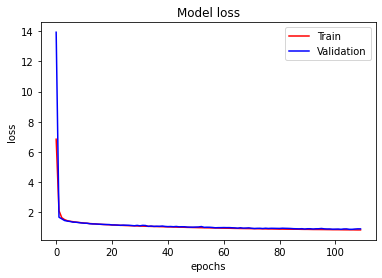

In [51]:
import matplotlib.pyplot as plt
  
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), loss_tr, color='red')
plt.plot(range(epochs), loss_val, color='blue')
plt.title('Model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('SleepEDF_conv10s_loss.png',bbox_inches = 'tight')
plt.show() 

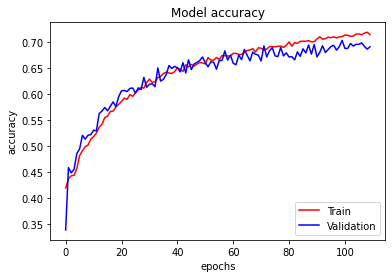

In [52]:
# plt.figure(figsize =(15, 10))
plt.plot(range(epochs), acc_tr, color='red')
plt.plot(range(epochs), acc_val, color='blue')
plt.title('Model accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.savefig('SleepEDF_conv10s_accuracy.png',bbox_inches = 'tight')
plt.show()

In [54]:
model = torch.load('/content/SleepEDF_Conv_30s_ep99_.pt').to(device)

In [55]:
loss_ep_test = 0
acc_ep_test = 0
for batch_idx, batch in enumerate(testLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        loss = CrossEL(pred, label)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        acc = (predicted == label).sum().item()
        acc = acc/batch['x'].shape[0]
        loss_ep_test += loss.item()
        acc_ep_test += acc

acc_ep_test = acc_ep_test/len(testLoader)
loss_ep_test = loss_ep_test/len(testLoader)

print(acc_ep_test)
print(loss_ep_test)

0.7394518097643098
0.8012365100297059


In [56]:
label_list = []
predicted_list = []
for batch_idx, batch in enumerate(testLoader):
        b,c,t = batch['x'].shape
        data = torch.reshape(batch['x'],(b*c,1,t))
        data = torch.Tensor(data).type(torch.float).to(device)

        x1 =  FE1.getRep(data)
        x2 =  FE2.embedding(data) 
        bc,f,t = x1.shape
        pred  = model.forward(x1,x2,b,c,f,t)
        CrossEL = torch.nn.CrossEntropyLoss()
        label = batch['y'].type(torch.float64).to(device)
        
        _, label =  torch.max(label, 1)  
        _, predicted = torch.max(pred, 1)
        label_list.extend(label.cpu().detach().numpy())
        predicted_list.extend(predicted.cpu().detach().numpy())

In [57]:
# confusion matrix 사용을 위한 라이브러리
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(label_list, predicted_list)
print(conf_matrix)

[[ 94   1  18   0   2  12]
 [ 25   2  32   0   0  29]
 [  9   1 468   7   5  23]
 [  0   0  39  26  11   0]
 [  0   0  19  18  45   0]
 [  8   1  20   0   0 142]]


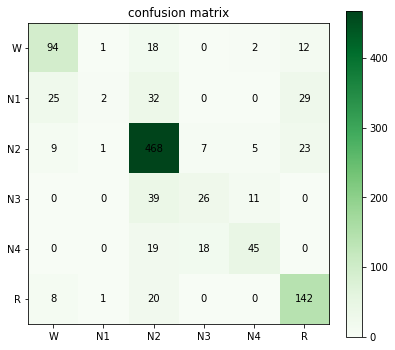

In [58]:
title = 'confusion matrix'
cmap=plt.cm.Greens
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)  # , cmap=plt.cm.Greens
plt.title(title, size=12)
plt.colorbar(fraction=0.05, pad=0.05)
tick_marks = np.arange(6, 6)
plt.yticks(np.arange(6), ('W','N1','N2','N3','N4','R'))
plt.xticks(np.arange(6), ('W','N1','N2','N3','N4','R'))


fmt = 'd' 
thresh = 1
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 ha="center", va="center", color="black" if conf_matrix[i, j] > thresh else "black")  #horizontalalignment
plt.savefig('SleepEDF_conv10s_confusion matrix.png',bbox_inches = 'tight')